# Getting derivatives of a noisy non-analytic function
Using this notebook to qualitativly compare several filtering schemes.

## Importing the raw data from csv

One thing is that we need to know the cutoff indices of the useful frames of each sequence.

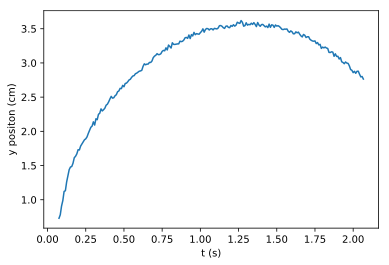

In [2]:
import csv
import numpy as np

y = []
t = []
f = open('position_data.csv')
droplet_position_data = csv.reader(f, delimiter=',')
next(droplet_position_data)
for row in droplet_position_data:
    y.append(row[0])
    t.append(row[1])

dt= float(t[0])
y = np.array(y[4:-2]).astype(float)
t = np.array(t[4:-2]).astype(float)

# plot with matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
%config InlineBackend.figure_formats=['svg']
%matplotlib inline

plt.plot(t,y)
plt.xlabel('t (s)')
plt.ylabel('y positon (cm)')

## Convolution with the derivative of a gaussian kernel

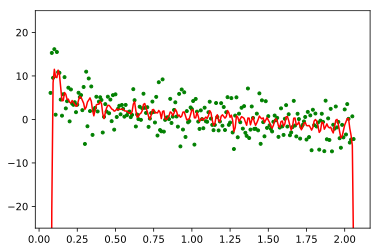

In [3]:
from scipy import ndimage

#Normalization:
dt = t[1] - t[0] # use np.diff(x) if x is not uniform
dtdt = dt**2

#First derivatives:
dy = np.diff(y) / dt
cy = np.convolve(y, [1,-1]) / dt
gy = ndimage.gaussian_filter1d(y, sigma=1, order=1, mode='wrap') / dt

#Second derivatives:
ddy = np.diff(y, 2) / dtdt
ccy = np.convolve(y, [1, -2, 1]) / dtdt
ggy = ndimage.gaussian_filter1d(y, sigma=1, order=2, mode='wrap') / dtdt

#Plotting:
plt.figure()
axes = plt.gca()
axes.set_ylim([-25,25])
#plt.plot(t, y, 'k', lw=2, label='original')
plt.plot(t[:-1], dy, 'g.', label='np.diff, 1')
#plt.plot(t, cy[:-1], 'b--', label='np.convolve, [1,-1]')
plt.plot(t, gy, 'r', label='gaussian, 1')
#plt.plot(t[:-2], ddy, 'g.', label='np.diff, 2')
#plt.plot(t, ccy[:-2], 'g--', label='np.convolve, [1,-2,1]')
#plt.plot(t, ggy, 'g', label='gaussian, 2')

## Wiener Filtering

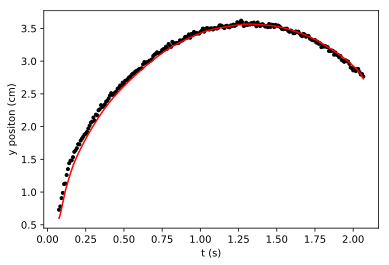

In [4]:
from scipy import signal
wiener_y = signal.wiener(y, mysize=20, noise=0.05)
wiener_y2 = signal.wiener(wiener_y, mysize=10, noise=0.05)
wiener_y3 = signal.wiener(wiener_y2, mysize=6, noise=0.005)
wiener_y4 = signal.wiener(wiener_y3, mysize=4, noise=0.005)
wiener_y5 = signal.wiener(wiener_y4, mysize=2, noise=0.005)

plt.plot(t,y , 'k.')
plt.plot(t,wiener_y5, 'r')
plt.xlabel('t (s)')
plt.ylabel('y positon (cm)')

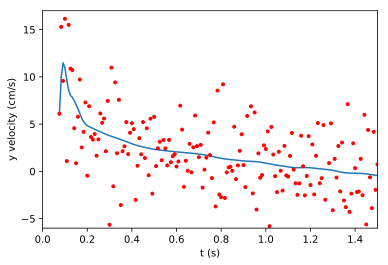

In [5]:
n = 0
dy2 = signal.wiener(np.diff(wiener_y5[n:]), mysize=3, noise=0.05 ) / dt

plt.figure()
plt.plot(t[n:-1],dy2)
plt.xlabel('t (s)')
plt.ylabel('y velocity (cm/s)')
axes = plt.gca()
axes.set_xlim([0,1.5])
axes.set_ylim([-6,17])
#plt.plot(x, f, 'k', lw=2, label='original')
plt.plot(t[:-1], dy, 'r.', label='np.diff, 1')
#plt.plot(x[:-2], ddf, 'g.', label='np.diff, 2')

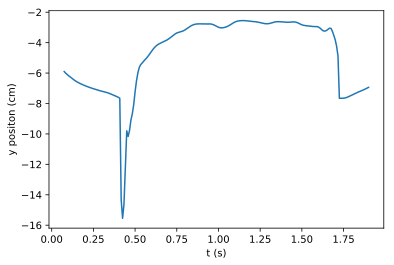

In [6]:
ddy2 = signal.wiener(np.diff(wiener_y5[n:],2), mysize=80, noise=0.005) / dtdt
#ddy2 = np.diff(wiener_y5[n:],2)/dtdt


plt.figure()
plt.plot(t[n:-20],ddy2[:-18])
plt.xlabel('t (s)')
plt.ylabel('y positon (cm)')
axes = plt.gca()
#axes.set_xlim([0.1,1.5])
#axes.set_ylim([-75,20])
#plt.plot(x, f, 'k', lw=2, label='original')
#plt.plot(t[:-1], df, 'r', label='np.diff, 1')
#plt.plot(x[:-2], ddf, 'g.', label='np.diff, 2')

How do I pick the 'mysize' parameter?

## Spline fits

218.0910977


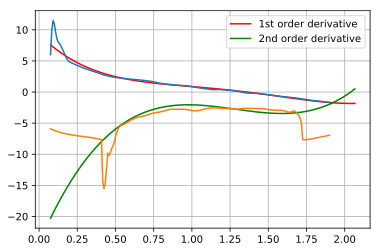

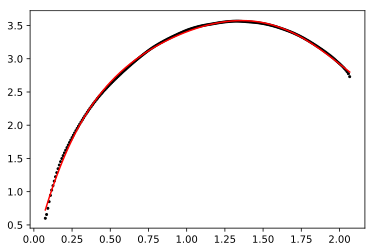

In [7]:
from scipy.interpolate import UnivariateSpline
npts = len(t)
k = 5 # 5th degree spline
s = npts - np.sqrt(2*npts) # smoothing factor
print(s)

spline_0 = UnivariateSpline(t, wiener_y5, k=k, s=.2)
spline_1 = UnivariateSpline(t, wiener_y5, k=k, s=.2).derivative(n=1)
spline_2 = UnivariateSpline(t, wiener_y5, k=k, s=.2).derivative(n=2)

# plot data, spline fit, and derivatives
fig = plt.figure()
ax = fig.add_subplot(111)

#ax.plot(t, y, 'ko', ms=2, label='data')
#ax.plot(t, spline_0(t), 'k', label='5th deg spline')
ax.plot(t, spline_1(t), 'r', label='1st order derivative')
ax.plot(t, spline_2(t), 'g', label='2nd order derivative')
ax.plot(t[n:-20],dy2[:-19])
ax.plot(t[n:-20],ddy2[:-18])

ax.legend(loc='best')
ax.grid()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t, wiener_y5, 'ko', ms=2, label='data')
ax.plot(t, spline_0(t), 'r', label='5th deg spline')

There might be something crazy going on here (e.g. the velocity is actually INCREASING), or is it an artefact of the data? Also: check these derivatives as a function of time. Note: limited to 5-order spline (or 4-order derivatives, but those may note be noticible with the resolution of my data anyway). Aslo I need a rule of thumb fo rpicking the smoothing factor, which is technically true for Gaussian convolution as well.

## FFT

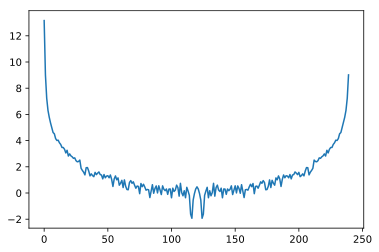

In [8]:
from scipy.fftpack import fft

f = fft(y)
p = np.log(np.real(f * np.conj(f)))
plt.plot(p)

Data is non-periodic...

## Savitzky-Golay Filtering

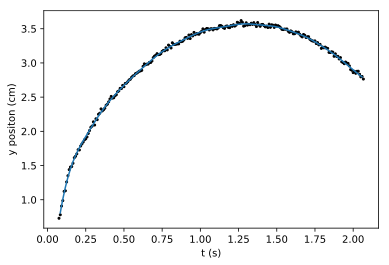

In [9]:
#yt = np.column_stack((y,t))
y_savgol = signal.savgol_filter(y, 25, 3, deriv=0, axis=0)
y_savgol1 = signal.savgol_filter(y_savgol, 25, 3, deriv=0, axis=0)
y_savgol2 = signal.savgol_filter(y_savgol1, 25, 3, deriv=0, axis=0)
y_savgol3 = signal.savgol_filter(y_savgol2, 25, 3, deriv=0, axis=0)
dy_savgol = signal.savgol_filter(y_savgol3, 25, 3, deriv=1, axis=0)/dt
ddy_savgol = signal.savgol_filter(y_savgol3, 25, 3, deriv=2, axis=0)/dtdt

plt.figure()

plt.xlabel('t (s)')
plt.ylabel('y positon (cm)')
axes = plt.gca()
#axes.set_xlim([0,1.5])
#axes.set_ylim([-100,20])
#plt.plot(t[1:-20],df2[1:-19])
plt.plot(t, y, 'ko', ms=2, label='data')
#plt.plot(t, spline_0(t), 'r', label='5th deg spline')
#plt.plot(t,wiener_y)
plt.plot(t[1:-1],y_savgol3[1:-1])

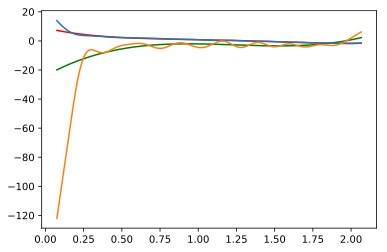

In [10]:
spline_0 = UnivariateSpline(t, y_savgol3, k=k, s=s)
spline_1 = UnivariateSpline(t, y_savgol3, k=k, s=s).derivative(n=1)
spline_2 = UnivariateSpline(t, y_savgol3, k=k, s=s).derivative(n=2)

# plot data, spline fit, and derivatives
fig = plt.figure()
ax = fig.add_subplot(111)

#ax.plot(t, y, 'ko', ms=2, label='data')
#ax.plot(t, spline_0(t), 'k', label='5th deg spline')
ax.plot(t, spline_1(t), 'r', label='1st order derivative')
ax.plot(t, spline_2(t), 'g', label='2nd order derivative')
ax.plot(t,dy_savgol)
ax.plot(t,ddy_savgol)


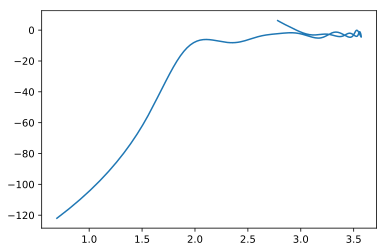

In [11]:
plt.plot(y_savgol3,ddy_savgol)

## Big grab bag of methods

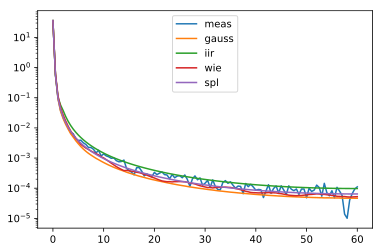

In [12]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
#import scipy.optimize as op

#def ssqe(sm, s, npts):
 #   return np.sqrt(np.sum(np.power(s-sm,2)))/npts

def testGauss(x, y, npts):
    b = gaussian(39, 10)
    #ga = filtfilt(b/b.sum(), [1.0], y)
    ga = filters.convolve1d(y, b/b.sum())
    plt.plot(x, ga)
    #print("gaerr", ssqe(ga, s, npts))
    return ga

def testButterworth(nyf, x, y, npts):
    b, a = butter(4, 1.5/nyf)
    fl = filtfilt(b, a, y)
    plt.plot(x,fl)
    #print("flerr", ssqe(fl, s, npts))
    return fl

def testWiener(x, y, npts):
    wi = wiener(y, mysize=29, noise=0.5)
    plt.plot(x,wi)
    #print "wieerr", ssqe(wi, s, npts)
    return wi

def testSpline(x, y, npts):
    #s = npts * (rmserror * np.fabs(y).max())**2
    sp = UnivariateSpline(x, y, k=5, s=20*2)
    dsp = UnivariateSpline(x, y, k=5, s=20*2).derivative(n=1)
    ddsp = UnivariateSpline(x, y, k=5, s=20*2).derivative(n=2)
    #plt.plot(x,sp(x))
    #print "splerr", ssqe(sp(x), s, npts)
    return sp(x), dsp(x), ddsp(x)

def plotPowerSpectrum(y, w):
    ft = np.fft.rfft(y)
    ps = np.real(ft*np.conj(ft))*np.square(dt)
    plt.plot(w, ps)

if __name__ == '__main__':
    npts = len(t)
    end = 8
    #dt = end/float(npts)
    nyf = 0.5/dt
    sigma = 0.5 
    x = t #np.linspace(0,end,npts)
    r = np.random.normal(scale = sigma, size=(npts))
    #s = np.sin(2*np.pi*x)#+np.sin(4*2*np.pi*x)
    #y = s + r
   # plt.plot(x,s)
   # plt.plot(x,y,ls='none',marker='.')
    ga = testGauss(x, y, npts)
    fl = testButterworth(nyf, x, y, npts)
    wi = testWiener(x, y, npts)
    sp = testSpline(x, y, npts)[0]
    dsp = testSpline(x, y, npts)[1]
    ddsp = testSpline(x, y, npts)[2]
    plt.legend(['meas','gauss','iir','wie','spl'], loc='upper center')
    plt.clf()
    w = np.fft.fftfreq(npts, d=dt)
    w = np.abs(w[:int(npts/2)+1]) #only freqs for real fft
    #plotPowerSpectrum(s, w)
    plotPowerSpectrum(y, w)
    plotPowerSpectrum(ga, w)
    plotPowerSpectrum(fl, w)
    plotPowerSpectrum(wi, w)
    plotPowerSpectrum(sp, w)
    plt.yscale('log')
    #plt.xlim([0,10])
    #plt.ylim([1E-8,None])
    plt.legend(['meas','gauss','iir','wie','spl'], loc='upper center')

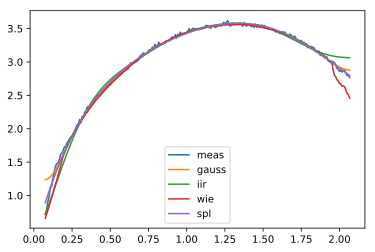

In [13]:
plt.plot(t,y,t,ga,t,fl,t,wi,t,sp)
plt.legend(['meas','gauss','iir','wie','spl'], loc='lower center')

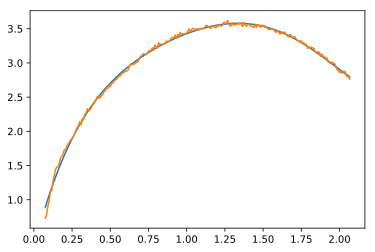

In [14]:
plt.plot(t,sp, t, y)

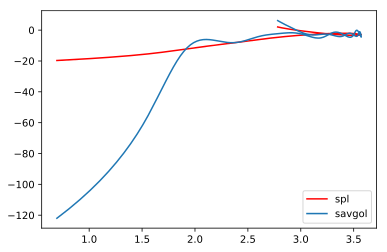

In [15]:
plt.plot(y_savgol3, ddsp, 'r')
plt.plot(y_savgol3,ddy_savgol)
plt.legend(['spl','savgol'], loc='lower right')
#plt.plot(t[2:], ccy[2:-2], 'ko', label='np.convolve, [1,-1]')

In [16]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')



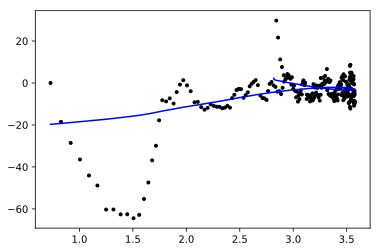

In [17]:
n = 5
nderiv = 2
y_sv = savitzky_golay(y,21, 3, deriv=nderiv)/dt**nderiv
y_sv0 = savitzky_golay(y,21, 3, deriv=0)
y_sv_sp = testSpline(t, y_sv0, npts=npts)



y_sv = y_sv[:-n]
plt.plot(y_sv0[:-n], y_sv, 'k.')
plt.plot(y_sv0, y_sv_sp[2], 'b')
#plt.plot(t, y, 'ko')
#plt.plot(t[10:-n], y_sv[10:], 'r')
#plt.plot(t, y_savgol)
#plt.plot(t[10:-(len(y)-len(y_sv))], y_sv[10:], 'ko')
#plt.plot(t, dsp, 'r')




## Total variance regularization

In [18]:
import prox_tv as ptv

y_tv = ptv.tv1_1d(y, 20, method='condat', sigma = 0.05)
y_tv2 = ptv.tv1_1d(y_tv, .05, method='condat', sigma = 0.05)
y_tv3 = ptv.tv1_1d(y_tv2, .05, method='condat', sigma = 0.05)

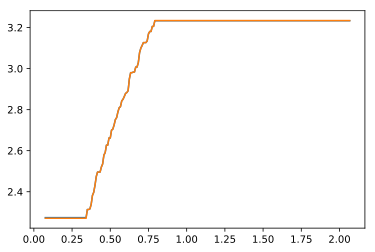

In [19]:
plt.plot(t, y_tv3, t, y_tv)

In [20]:
help(ptv.tv1_1d)

Help on function tv1_1d in module prox_tv:

tv1_1d(x, w, method='hybridtautstring', sigma=0.05, maxbacktracks=None)
    1D proximal operator for :math:`\ell_1`.
    
    Specifically, this optimizes the following program:
    
    .. math::
    
        \mathrm{min}_y \frac{1}{2} \|x-y\|^2 + w \sum_i |y_i - y_{i+1}|.
    
    Parameters
    ----------
    x : numpy array
        The signal we are approximating.
    w : float
        The non-negative weight in the optimization problem.
    method : str
        The algorithm to be used, one of:
    
        * ``'classictautstring'`` - classic Taut String method
        * ``'linearizedtautstring'`` - linearized Taut String method
        * ``'hybridtautstring'`` - hybrid classic+linear Taut String method
        * ``'pn'`` - projected Newton.
        * ``'condat'`` - Condat's segment construction method.
        * ``'dp'`` - Johnson's dynamic programming algorithm.
        * ``'condattautstring'`` - Condat's implementation of classic taut